In [1]:
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO
import itertools as it

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

from kaggle_camera_model_id_lib.utils import PechkaBot, ImageList, NpzFolder, NCrops, TifFolderExFiles
from kaggle_camera_model_id_lib.models import VggHead, StyleVggHead, IEEEfcn, ResNetFC, FatNet1,InceptionResNetV2
from kaggle_camera_model_id_lib.utils import jpg_compress, equalize_v_hist, hsv_convert
from kaggle_camera_model_id_lib.utils import scale_crop_pad, gamma_correction
from kaggle_camera_model_id_lib.utils import patch_quality_dich, n_random_crops, n_pseudorandom_crops
from kaggle_camera_model_id_lib.models import ResNetDense, ResNetDenseFC

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import pairwise_distances

In [2]:
test_path = '/home/mephistopheies/storage2/data/camera-model-id/raw/test/'
model_path = '/home/mephistopheies/storage2/data/camera-model-id/models/ResNetDenseFC34/256_random_aug_kaggle_10_pretrained_zfc_flickr_noval_nocenter/pseudo_phase_2/checkpoint.tar'
model_type = 'ResNetDenseFC34_pretrained_zfc'
n_classes = 10
crop_size = 256
step = 128
batch_size = 5
num_workers = 1

to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

model_factory = {
    'Vgg19Head_E_2b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_2b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_3b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_3b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='E', batch_norm=True),
    'Vgg11Head_A_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=True),
    'Vgg11Head_A': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=False),
    'StyleVggHead_bn': lambda n_classes: StyleVggHead(num_classes=n_classes, load_vgg_bn=True),
    'IEEEfcn': lambda n_classes: IEEEfcn(n_classes),
    'resnet18fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'resnet18fc': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet=None),
    'resnet18X_pretrained': lambda n_classes: ResNetX(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'InceptionResNetV2fc_5_10_4': lambda n_classes: InceptionResNetV2fc(
        num_classes=n_classes, nun_block35=5, num_block17=10, num_block8=4),
    'InceptionResNetV2fcSmall_5_10': lambda n_classes: InceptionResNetV2fcSmall(
        num_classes=n_classes, nun_block35=5, num_block17=10),
    'resnet34fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34'),
    'resnet34fc_pretrained_maxpool': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34', pool_type='max'),
    'resnet50fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet50'),
    'FatNet1': lambda n_classes: FatNet1(n_classes),
    'resnet34X_pretrained_maxpool': lambda n_classes: ResNetX(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34', pool_type='max'),
    'resnet50X_pretrained_maxpool': lambda n_classes: ResNetX(
        models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet50', pool_type='max'),
    'InceptionResNetV2': lambda n_classes: InceptionResNetV2(num_classes=n_classes),
    'ResNetDense34_pretrained': lambda n_classes: ResNetDense(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34'),
    'ResNetDenseFC34_pretrained': lambda n_classes: ResNetDenseFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34', 
        zero_first_center=False),
    'ResNetDenseFC34_pretrained_zfc': lambda n_classes: ResNetDenseFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34', 
        zero_first_center=True)
}

model = model_factory[model_type](n_classes)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
loss_train = checkpoint['loss_train']
acc_train = checkpoint['acc_train']
loss_val = checkpoint['loss_val']
acc_val = checkpoint['acc_val']
class_to_idx = checkpoint['class_to_idx']
idx2class = dict([(v, k) for (k, v) in class_to_idx.items()])
print('Last state:\n  TLoss: %0.6f\n  TAcc:  %0.4f\n  VLoss: %0.6f\n  VAcc:  %0.4f' % 
    (loss_train[-1], acc_train[-1], loss_val[-1], acc_val[-1]))
del(checkpoint)
model = model.cuda()
model = model.eval()

hooks = []
avg_pool = nn.AdaptiveAvgPool2d(1)

def extract_features_avg(self, input, output):
    #self.last_values_avg = avg_pool(output).cpu().data.numpy().squeeze()
    #self.last_values_avg = avg_pool(output)
    pass

def extract_features(self, input, output):
    #self.last_values = output.cpu().data.numpy().squeeze()
    self.last_input_values = avg_pool(input[0])

hooks.append(model.project.register_forward_hook(extract_features))

ds_test_0 = TifFolderExFiles(
    test_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(np.array(img), crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
    ]))

ds_test_90 = TifFolderExFiles(
    test_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(np.array(img.rotate(90)), crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
    ]))

ds_test_180 = TifFolderExFiles(
    test_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(np.array(img.rotate(180)), crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
    ]))

ds_test_270 = TifFolderExFiles(
    test_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(np.array(img.rotate(270)), crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
    ]))

ds_test_list = [ds_test_0, ds_test_90, ds_test_180, ds_test_270]

Last state:
  TLoss: 0.032280
  TAcc:  0.9895
  VLoss: 0.000000
  VAcc:  0.0000


In [5]:
# batch_size = 1

# d = {}
# for ds_test in ds_test_list:
#     test_loader = torch.utils.data.DataLoader(    
#         ds_test,
#         batch_size=batch_size, 
#         shuffle=False,
#         num_workers=1, 
#         pin_memory=True)



#     for X, Y, files in tqdm_notebook(test_loader, total=int(len(ds_test.imgs)/batch_size)):
#         fname = os.path.basename(files[0])
#         X = X.squeeze()
#         X_var = Variable(X.cuda(), volatile=True)
#         log_p = model(X_var)
#         p = F.softmax(log_p, dim=1) #.mean(dim=1)
#         p = p.prod(dim=0).pow(1/p.shape[0])
#         f = model.project.last_input_values.squeeze().mean(dim=0)
        
#         if fname not in d:
#             d[fname] = []
        
#         d[fname].append({
#             'p': p.cpu().data.numpy(),
#             'f': f.cpu().data.numpy()                
#         })
#         d[fname][-1]['ci'] = np.argmax(d[fname][-1]['p'])
#         d[fname][-1]['c'] = idx2class[d[fname][-1]['ci']]
        

# for fname, dlist in tqdm_notebook(d.items(), total=len(d)):
#     f = np.array([x['f'] for x in dlist]).max(axis=0)
#     f /= f.sum()
#     p = np.array([x['p'] for x in dlist]).max(axis=0)
#     p /= p.sum()
    
#     d[fname] = {}
#     d[fname]['f'] = f
#     d[fname]['p'] = p
#     d[fname]['ci'] = np.argmax(p)
#     d[fname]['c'] = idx2class[d[fname]['ci']]
                
                
                
                
# with open('./../../tmp/d.pkl', 'wb') as f:
#     pickle.dump(d, f)


del(model)
cols = sns.color_palette('hls', 10)

with open('./../../tmp/d.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
uid2col = {}
m_f = np.zeros((len(data), 960))
files = []
for ix, (fname, d) in enumerate(data.items()):
    m_f[ix, :] = d['f']
    uid2col[ix] = d['ci']
    files.append(fname)
fname2idx = dict([(v, k) for (k, v) in enumerate(files)])

In [7]:
pca = PCA(n_components=50)
m_f_pca = pca.fit_transform(m_f)

In [8]:
tsne = TSNE(n_components=2, metric='euclidean', verbose=True)
m_f_pca_tsne = tsne.fit_transform(m_f_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2640 samples in 0.009s...
[t-SNE] Computed neighbors for 2640 samples in 0.691s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2640
[t-SNE] Computed conditional probabilities for sample 2000 / 2640
[t-SNE] Computed conditional probabilities for sample 2640 / 2640
[t-SNE] Mean sigma: 0.003652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.844795
[t-SNE] Error after 1000 iterations: 0.703995


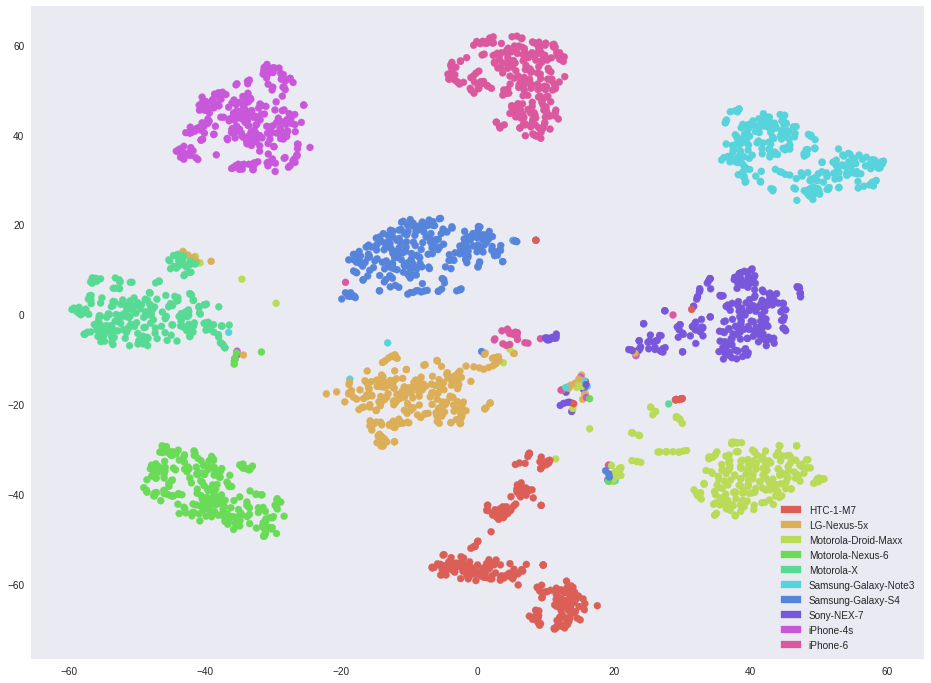

In [9]:
plt.scatter(m_f_pca_tsne[:, 0], m_f_pca_tsne[:, 1], 
            c=[cols[uid2col[i]] for i in range(m_f_pca_tsne.shape[0])])
plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])

In [10]:
deuc_m_f = pairwise_distances(m_f, metric='euclidean', n_jobs=8)
dcos_m_f = pairwise_distances(m_f, metric='cosine', n_jobs=8)
deuc_m_f_pca_tsne = pairwise_distances(m_f_pca_tsne, metric='euclidean', n_jobs=8)
deuc_m_f_pca = pairwise_distances(m_f_pca, metric='euclidean', n_jobs=8)

In [11]:
pd.Series([np.max(d['p']) for (_, d) in data.items()]).describe()

count    2640.000000
mean        0.970272
std         0.104456
min         0.253474
25%         0.997973
50%         0.999946
75%         1.000000
max         1.000000
dtype: float64

In [18]:
ix_manip = np.array([i for (i, fname) in enumerate(files) if '_manip' in fname])
ix_unalt = np.array([i for (i, fname) in enumerate(files) if '_unalt' in fname])

In [61]:
def knn_online(dmat, k_max=None, t_pseudo=0.9997, var_type=None, bal=False, verbose=True):
    pseudo = set([fname for (fname, d) in data.items() if np.max(d['p']) > t_pseudo])

    if verbose:
        print(pd.Series([data[fname]['c'] for fname in pseudo]).value_counts())

    counts = pd.Series([data[fname]['c'] for fname in pseudo]).value_counts().to_dict()

    if verbose:
        idxs = np.array([fname2idx[fname] for fname in pseudo])
        plt.scatter(m_f_pca_tsne[idxs, 0], m_f_pca_tsne[idxs, 1], 
                    c=[cols[uid2col[i]] for i in idxs])
        plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])
        plt.show()

    def gaussian_kernel(x, v):
        return np.exp(-(x*x)/(2*v))

    unlabelled = sorted(
        [(ix, fname, np.max(data[fname]['p'])) for (ix, fname) in enumerate(files) if fname not in pseudo], 
        key=lambda t: t[-1], reverse=True)

    pred = [(fname, data[fname]['c']) for fname in pseudo]

    if k_max is not None:
        k_max = min(counts.values())

    for ix, fname, _ in unlabelled:

        all_nn = [(fname, dist, data[fname]['c']) for (fname, dist) in 
                  sorted(zip(files, dmat[ix, :]), key=lambda t: t[-1]) if fname in pseudo]

        if var_type is None:
            var = np.var([x for (_, x, _) in all_nn]) if k_max is None \
                          else np.var([x for (_, x, _) in all_nn[:k_max]])
        else:
            var = var_type

        if k_max is not None:
            n = gaussian_kernel(np.max([x for (_, x, _) in all_nn[:k_max]]), var)
        else:
            n = gaussian_kernel(np.max([x for (_, x, _) in all_nn]), var)

        votes = defaultdict(float)
        if k_max is not None:
            cw = [(c, gaussian_kernel(x, var)/n) for (_, x, c) in all_nn[:k_max]]
        else:
            cw = [(c, gaussian_kernel(x, var)/n) for (_, x, c) in all_nn]
        for c, w in cw:
            votes[c] += w

        if k_max is None:
            for c, w in votes.items():
                votes[c] /= counts[c]

        votes = sorted(votes.items(), key=lambda t: t[1], reverse=True)

        if bal:
            cdone = set([k for (k, v) in 
                        pd.Series([c for (_, c) in pred]).value_counts().to_dict().items() 
                        if v >= 264])
            
#             cdone_manip = set([k for (k, v) in 
#                                pd.Series([c for (fname, c) in pred if '_manip' in fname]
#                                         ).value_counts().to_dict().items() 
#                          if v >= 132])
            
#             cdone_unalt = set([k for (k, v) in 
#                                pd.Series([c for (fname, c) in pred if '_unalt' in fname]
#                                         ).value_counts().to_dict().items() 
#                          if v >= 132])
            
            #if len(cdone_manip) > 1 and len(cdone_unalt) > 1:
            #    return cdone_manip, cdone_unalt
            
            votes = [(k, v) for (k, v) in votes 
                     if k not in cdone_manip and k not in cdone]



        pseudo = pseudo.union([fname])
        pred.append((fname, votes[0][0]))
        
    return pred

# pred = knn_online(deuc_m_f, k_max=None, t_pseudo=0.9997, var_type=None, bal=True, verbose=True)
    
# print(1 - np.abs(pd.Series([c for (_, c) in pred]).value_counts() - 264).sum()/2640)

# plt.scatter(m_f_pca_tsne[:, 0], m_f_pca_tsne[:, 1], 
#             c=[cols[class_to_idx[dict(pred)[fname]]] for fname in files])
# plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])
# plt.show()

In [79]:
def knn_online(dmat, k_max=None, t_pseudo=0.9997, var_type=None, bal=False, verbose=True, subgroup='_manip'):
    pseudo = set([fname for (fname, d) in data.items() if np.max(d['p']) > t_pseudo and subgroup in fname])

    if verbose:
        print(pd.Series([data[fname]['c'] for fname in pseudo]).value_counts())

    counts = pd.Series([data[fname]['c'] for fname in pseudo]).value_counts().to_dict()

    if verbose:
        idxs = np.array([fname2idx[fname] for fname in pseudo])
        plt.scatter(m_f_pca_tsne[idxs, 0], m_f_pca_tsne[idxs, 1], 
                    c=[cols[uid2col[i]] for i in idxs])
        plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])
        plt.show()

    def gaussian_kernel(x, v):
        return np.exp(-(x*x)/(2*v))
    
    files_loc = [fname for fname in files if subgroup in fname]

    unlabelled = sorted(
        [(ix, fname, np.max(data[fname]['p'])) for (ix, fname) in enumerate(files_loc) if fname not in pseudo], 
        key=lambda t: t[-1], reverse=True)

    pred = [(fname, data[fname]['c']) for fname in pseudo]

    if k_max is not None:
        k_max = min(counts.values())

    for ix, fname, _ in unlabelled:

        all_nn = [(fname, dist, data[fname]['c']) for (fname, dist) in 
                  sorted(zip(files_loc, dmat[ix, :]), key=lambda t: t[-1]) if fname in pseudo]

        if var_type is None:
            var = np.var([x for (_, x, _) in all_nn]) if k_max is None \
                          else np.var([x for (_, x, _) in all_nn[:k_max]])
        else:
            var = var_type

        if k_max is not None:
            n = gaussian_kernel(np.max([x for (_, x, _) in all_nn[:k_max]]), var)
        else:
            n = gaussian_kernel(np.max([x for (_, x, _) in all_nn]), var)

        votes = defaultdict(float)
        if k_max is not None:
            cw = [(c, gaussian_kernel(x, var)/n) for (_, x, c) in all_nn[:k_max]]
        else:
            cw = [(c, gaussian_kernel(x, var)/n) for (_, x, c) in all_nn]
        for c, w in cw:
            votes[c] += w

        if k_max is None:
            for c, w in votes.items():
                votes[c] /= counts[c]

        votes = sorted(votes.items(), key=lambda t: t[1], reverse=True)

        if bal:
            cdone = set([k for (k, v) in 
                        pd.Series([c for (_, c) in pred]).value_counts().to_dict().items() 
                        if v >= int(dmat.shape[0]/10)])
            
            votes = [(k, v) for (k, v) in votes 
                     if k not in cdone_manip and k not in cdone]



        pseudo = pseudo.union([fname])
        pred.append((fname, votes[0][0]))
        
    return pred

# pred = knn_online(deuc_m_f, k_max=None, t_pseudo=0.9997, var_type=None, bal=True, verbose=True)
    
# print(1 - np.abs(pd.Series([c for (_, c) in pred]).value_counts() - 264).sum()/2640)

# plt.scatter(m_f_pca_tsne[:, 0], m_f_pca_tsne[:, 1], 
#             c=[cols[class_to_idx[dict(pred)[fname]]] for fname in files])
# plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])
# plt.show()

In [83]:
pred = knn_online(deuc_m_f[ix_manip, :][:, ix_manip], 
                  k_max=None, t_pseudo=0.9997, var_type=None, bal=True, verbose=False)

In [84]:
pd.Series([c for (_, c) in pred]).value_counts()

Samsung-Galaxy-S4       132
Samsung-Galaxy-Note3    132
Sony-NEX-7              132
iPhone-6                132
HTC-1-M7                132
iPhone-4s               132
Motorola-Nexus-6        132
Motorola-X              132
LG-Nexus-5x             132
Motorola-Droid-Maxx     132
dtype: int64

In [85]:
dm_list = [deuc_m_f, dcos_m_f, deuc_m_f_pca, deuc_m_f_pca_tsne]
k_max_list = [None, 'min']
var_type_list = [None, 0.001, 0.0001]
t_pseudo_list = [0.975, 0.99, 0.999, 0.9997, 0.9999, 0.99995]

n = len(dm_list)*len(k_max_list)*len(var_type_list)*len(t_pseudo_list)
n

144

In [104]:
params_iter = it.product(
    range(len(dm_list)), 
    range(len(k_max_list)), 
    range(len(var_type_list)), 
    range(len(t_pseudo_list)))

res_knn = []

for ix_dm, ix_k_max, ix_var_type, ix_t_pseudo in tqdm_notebook(params_iter, total=n):
#     pred = knn_online(
#         dm_list[ix_dm], 
#         k_max=k_max_list[ix_k_max], 
#         t_pseudo=t_pseudo_list[ix_t_pseudo], 
#         var_type=var_type_list[ix_var_type], 
#         bal=False, 
#         verbose=False)

    pred_unalt = knn_online(
        dm_list[ix_dm][ix_unalt, :][:, ix_unalt], 
        k_max=k_max_list[ix_k_max], 
        t_pseudo=t_pseudo_list[ix_t_pseudo], 
        var_type=var_type_list[ix_var_type], 
        bal=False, 
        verbose=False,
        subgroup='_unalt')
    
    pred_manip = knn_online(
        dm_list[ix_dm][ix_manip, :][:, ix_manip], 
        k_max=k_max_list[ix_k_max], 
        t_pseudo=t_pseudo_list[ix_t_pseudo], 
        var_type=var_type_list[ix_var_type], 
        bal=False, 
        verbose=False,
        subgroup='_manip')
    
    pred = pred_manip + pred_unalt

    res_knn.append((
        (ix_dm, ix_k_max, ix_var_type, ix_t_pseudo),
        pred
    ))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


In [105]:
measures = []
for ix, ((ix_dm, ix_k_max, ix_var_type, ix_t_pseudo), pred) in enumerate(res_knn):
    q = 1 - np.abs(pd.Series([c for (_, c) in pred]).value_counts() - 264).sum()/2640
    e = -(pd.Series([c for (_, c) in pred]).value_counts(normalize=True)*np.log(pd.Series([c for (_, c) in pred]).value_counts(normalize=True))).sum()
    measures.append((ix, q, e))

In [106]:
sorted(measures, key=lambda t: t[1], reverse=True)[:5]

[(5, 0.99090909090909096, 2.3025193373296582),
 (4, 0.99015151515151512, 2.3025019764711891),
 (3, 0.98939393939393938, 2.3024563836993557),
 (0, 0.98863636363636365, 2.302392657340651),
 (1, 0.98863636363636365, 2.302394081358587)]

In [107]:
sorted(measures, key=lambda t: t[2], reverse=True)[:5]

[(5, 0.99090909090909096, 2.3025193373296582),
 (4, 0.99015151515151512, 2.3025019764711891),
 (3, 0.98939393939393938, 2.3024563836993557),
 (75, 0.98787878787878791, 2.3024373191600653),
 (2, 0.98863636363636365, 2.3024133370838427)]

In [108]:
pd.Series([c for (_, c) in res_knn[5][1]]).value_counts()

LG-Nexus-5x             271
Motorola-X              267
HTC-1-M7                265
iPhone-4s               265
Sony-NEX-7              264
Samsung-Galaxy-S4       262
iPhone-6                262
Samsung-Galaxy-Note3    262
Motorola-Nexus-6        262
Motorola-Droid-Maxx     260
dtype: int64

In [118]:
# pd.Series([c for (_, c) in res_knn[36][1]]).value_counts()

In [121]:
ix_dm, ix_k_max, ix_var_type, ix_t_pseudo = res_knn[5][0]

ix_dm, ix_k_max, ix_var_type, ix_t_pseudo

(0, 0, 0, 5)

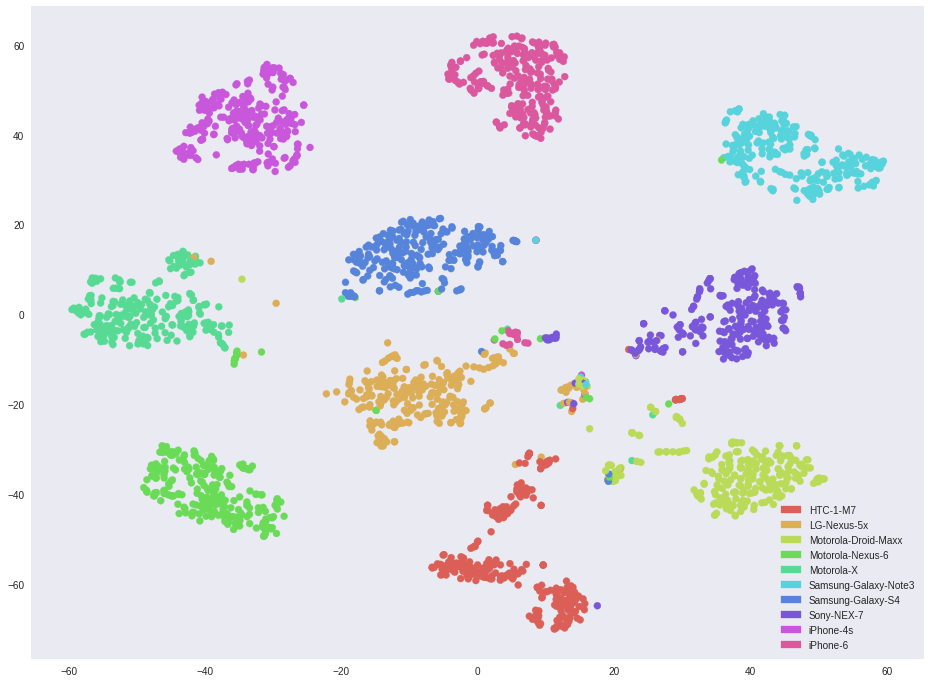

In [122]:
# pred = knn_online(
#     dm_list[ix_dm], 
#     k_max=k_max_list[ix_k_max], 
#     t_pseudo=t_pseudo_list[ix_t_pseudo], 
#     var_type=var_type_list[ix_var_type], 
#     bal=False, 
#     verbose=True)

pred_unalt = knn_online(
    dm_list[ix_dm][ix_unalt, :][:, ix_unalt], 
    k_max=k_max_list[ix_k_max], 
    t_pseudo=t_pseudo_list[ix_t_pseudo], 
    var_type=var_type_list[ix_var_type], 
    bal=False, 
    verbose=False,
    subgroup='_unalt')

pred_manip = knn_online(
    dm_list[ix_dm][ix_manip, :][:, ix_manip], 
    k_max=k_max_list[ix_k_max], 
    t_pseudo=t_pseudo_list[ix_t_pseudo], 
    var_type=var_type_list[ix_var_type], 
    bal=False, 
    verbose=False,
    subgroup='_manip')

pred = pred_manip + pred_unalt

plt.scatter(m_f_pca_tsne[:, 0], m_f_pca_tsne[:, 1], 
            c=[cols[class_to_idx[dict(pred)[fname]]] for fname in files])
plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])
plt.show()

0 0 0 5
iPhone-6                125
iPhone-4s               116
Motorola-Droid-Maxx     107
Samsung-Galaxy-S4        97
Motorola-X               84
Sony-NEX-7               83
HTC-1-M7                 79
Samsung-Galaxy-Note3     77
LG-Nexus-5x              42
Motorola-Nexus-6         21
dtype: int64


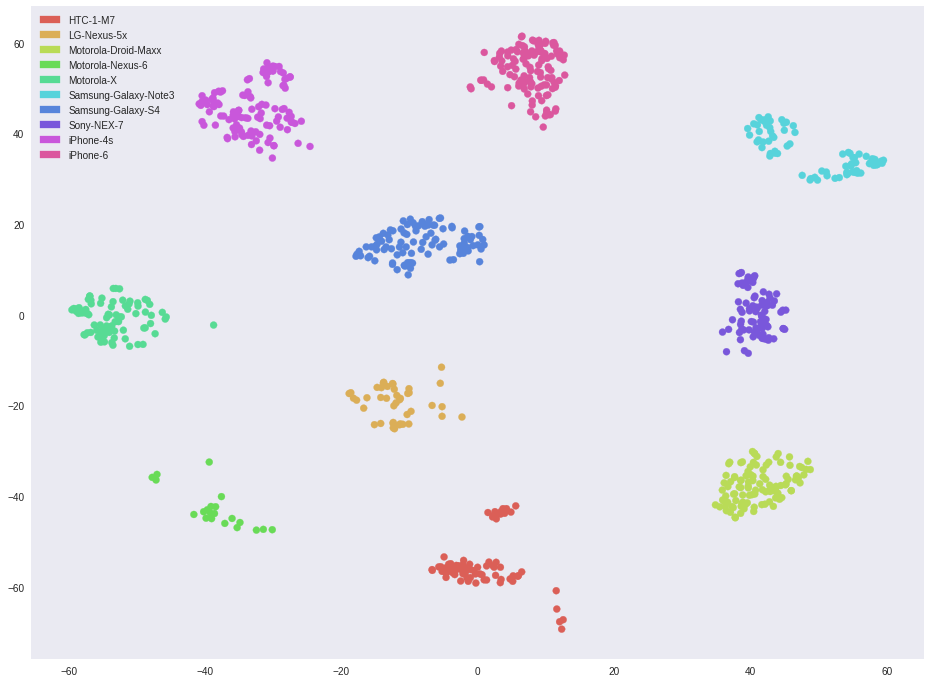

iPhone-6                95
Motorola-Droid-Maxx     80
iPhone-4s               66
Samsung-Galaxy-S4       58
HTC-1-M7                50
Samsung-Galaxy-Note3    44
Sony-NEX-7              44
Motorola-X              25
LG-Nexus-5x             12
Motorola-Nexus-6         5
dtype: int64


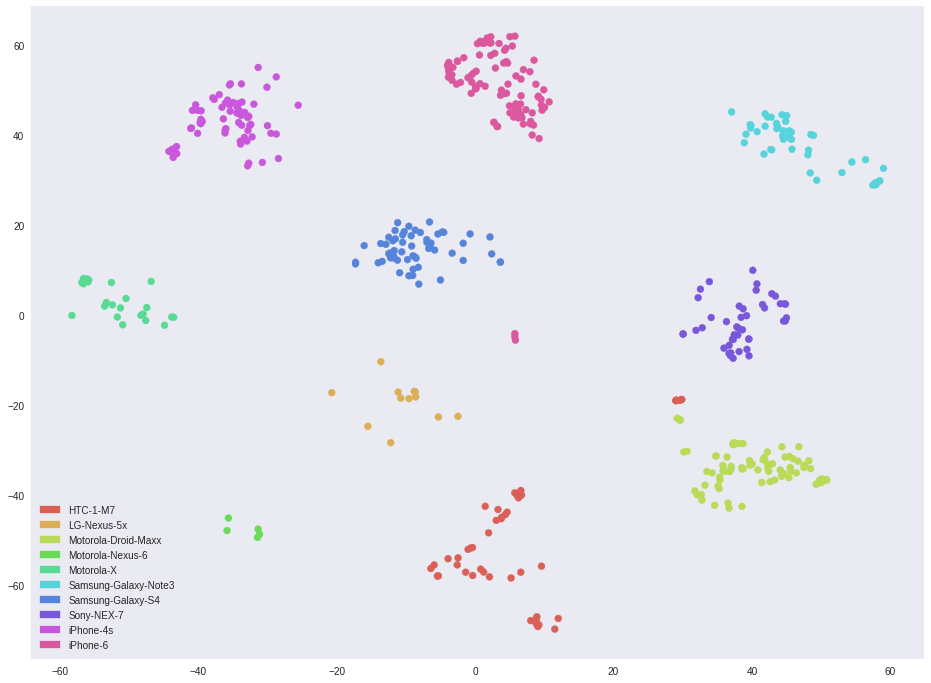

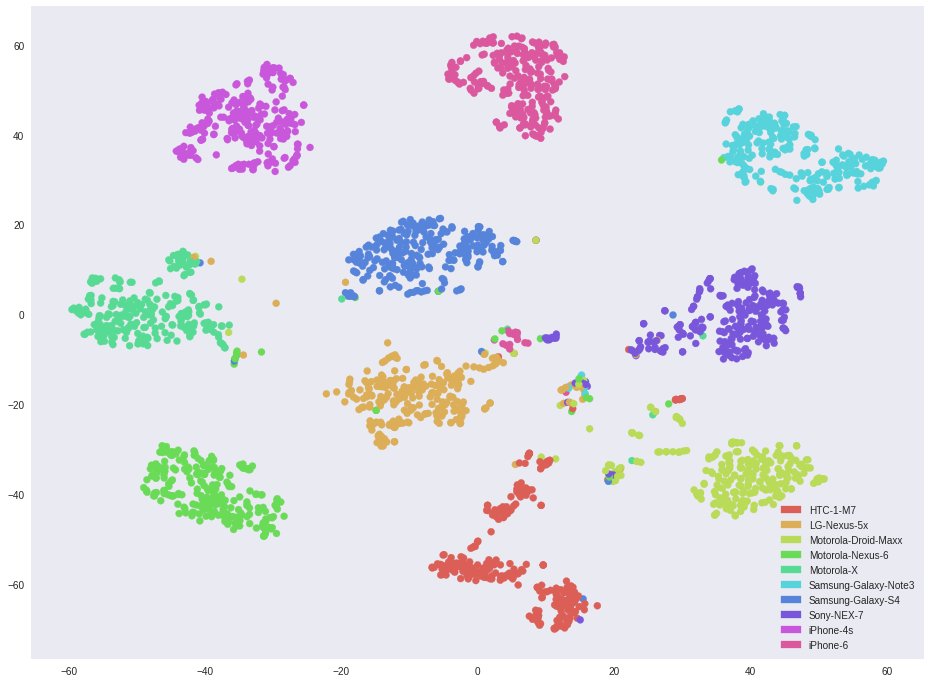

In [123]:
ix_dm, ix_k_max, ix_var_type, ix_t_pseudo = res_knn[5][0]
print(ix_dm, ix_k_max, ix_var_type, ix_t_pseudo)

# pred = knn_online(
#     dm_list[ix_dm], 
#     k_max=k_max_list[ix_k_max], 
#     t_pseudo=t_pseudo_list[ix_t_pseudo], 
#     var_type=var_type_list[ix_var_type], 
#     bal=True, 
#     verbose=True)

pred_unalt = knn_online(
    dm_list[ix_dm][ix_unalt, :][:, ix_unalt], 
    k_max=k_max_list[ix_k_max], 
    t_pseudo=t_pseudo_list[ix_t_pseudo], 
    var_type=var_type_list[ix_var_type], 
    bal=True, 
    verbose=True,
    subgroup='_unalt')

pred_manip = knn_online(
    dm_list[ix_dm][ix_manip, :][:, ix_manip], 
    k_max=k_max_list[ix_k_max], 
    t_pseudo=t_pseudo_list[ix_t_pseudo], 
    var_type=var_type_list[ix_var_type], 
    bal=True, 
    verbose=True,
    subgroup='_manip')

pred = pred_manip + pred_unalt

plt.scatter(m_f_pca_tsne[:, 0], m_f_pca_tsne[:, 1], 
            c=[cols[class_to_idx[dict(pred)[fname]]] for fname in files])
plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])
plt.show()

In [125]:
pd.Series([c for (_, c) in pred]).value_counts()

Samsung-Galaxy-S4       264
iPhone-6                264
HTC-1-M7                264
Motorola-X              264
Samsung-Galaxy-Note3    264
Sony-NEX-7              264
iPhone-4s               264
Motorola-Nexus-6        264
LG-Nexus-5x             264
Motorola-Droid-Maxx     264
dtype: int64

In [126]:
res = pred

out_dir = '/home/mephistopheies/storage2/data/camera-model-id/submit/'

with open(os.path.join(out_dir, 'submit__unalt.csv'.lower()), 'w') as f:
    f.write('fname,camera\n')
    for fname, c in res:
        if '_unalt' in fname:
            f.write('%s,%s\n' % (fname, c))
        else:
            f.write('%s,%s\n' % (fname, 'no_class'))
            
            
with open(os.path.join(out_dir, 'submit__manip.csv'.lower()), 'w') as f:
    f.write('fname,camera\n')
    for fname, c in res:
        if '_manip' in fname:
            f.write('%s,%s\n' % (fname, c))
        else:
            f.write('%s,%s\n' % (fname, 'no_class'))
            
            
with open(os.path.join(out_dir, 'submit.csv'.lower()), 'w') as f:
    f.write('fname,camera\n')
    for fname, c in res:
        f.write('%s,%s\n' % (fname, c))